## Installations

In [1]:
!pip install torch torchvision --quiet
!pip install transformers timm pillow --quiet

## OWL-ViT for Region-Seeds Generation

In [2]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import torch
from PIL import Image
import matplotlib.pyplot as plt
import requests

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

### Upload Image and Text Prompt

In [3]:
image_url = "https://ultralytics.com/images/zidane.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

text_queries = [["man"]]

inputs = processor(text=text_queries, images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

In [4]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

boxes = results["boxes"]
scores = results["scores"]
labels = results["labels"]

print(boxes.shape)

torch.Size([2, 4])


/usr/local/lib/python3.12/dist-packages/transformers/models/owlvit/processing_owlvit.py:217: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


### Display Bbox(s)

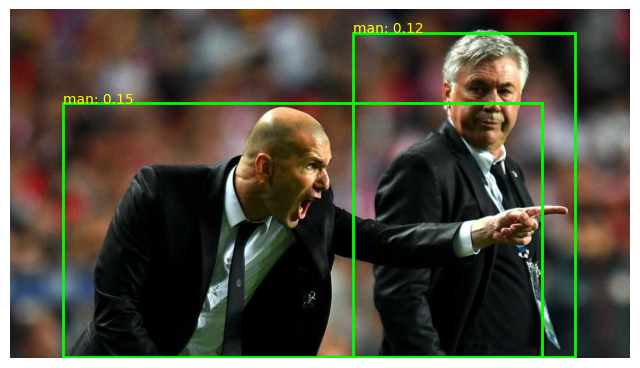

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(image)
ax = plt.gca()

for box, score, label in zip(boxes, scores, labels):
    if score < 0.1:
        continue
    x0, y0, x1, y1 = box.tolist()
    w, h = x1 - x0, y1 - y0

    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='lime', linewidth=2, fill=False))
    ax.text(x0, y0, f"{text_queries[0][label]}: {score:.2f}", color='yellow')

plt.axis('off')
plt.show()

## SAM2 Model

In [6]:
from transformers import Sam2Processor, Sam2Model, infer_device

device = infer_device()

sam2_model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-large").to(device)
sam2_processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-large")

config.json: 0.00B [00:00, ?B/s]

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/898M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

In [7]:
from transformers import Sam2Processor, Sam2Model, infer_device

device = infer_device()

sam2_model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-large").to(device)
sam2_processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-large")

batched_boxes = boxes.unsqueeze(0)
print(batched_boxes.shape)

inputs = sam2_processor(
    images=image,
    input_boxes=batched_boxes,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = sam2_model(**inputs)

masks = sam2_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"],
    binarize=True,
    mask_threshold=0.5
)[0]

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


torch.Size([1, 2, 4])


In [8]:
print(masks.shape)

torch.Size([2, 3, 720, 1280])


### Display Mask

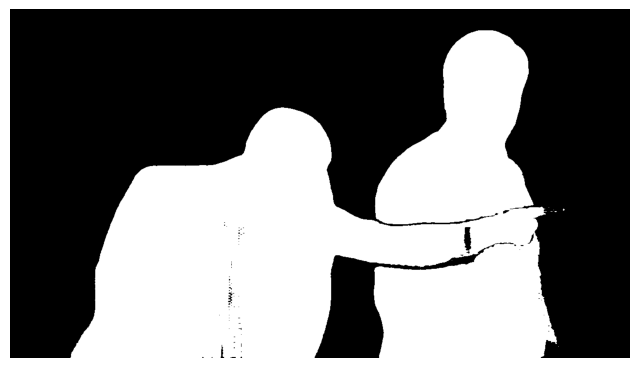

In [10]:
import matplotlib.pyplot as plt

# remove channel dimension [num_masks, H, W]
binary_masks = (masks.sum(dim=1) > 0.5).cpu()

final_binary_mask = binary_masks.any(dim=0).numpy().astype(int)

plt.figure(figsize=(8, 8))
plt.imshow(final_binary_mask, cmap="gray")
plt.axis("off")
plt.show()
